# CS 39AA - Notebook C: Improving the Airline Tweet Model

We'll now revisit the Airline Tweet dataset and try to resolve some of the issues that identified at the end of [Notebook A](https://github/sgeinitz/cs39aa_notebooks/blob/main/nb_A_text_data_and_pandas.ipynb). 

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/sgeinitz/cs39aa_notebooks/blob/main/nb_C_airline_tweets_take2.ipynb)

If you recall from Notebook A, we created a very simple ad hoc model that simply counted the most frequently occuring words in each of the three distinct classes (positive, negative, and neutral). Our '_model_' then would take a new tweet and check to see how many times these words appeared. If more positive words appeared, then we assigned that label, and so on for negative and neutral. 

At the end we listed three issues or areas for improvement. These were:
1. __Better Tokenization:__ The tokenization is very crude right now. Simply splitting a tweet into tokens with the 'SPACE' character as a delimiter means that positive tokens like _"awesome."_ and _"awesome!"_ are considered as two different tokens. Cases such as that one are relatively easy to solve since it just meaning removing some punctuation. However, different forms of a word, such as _"delay"_ and _"delayed"_ can cause some issues too. For our ad hoc modeling approach above, resolving these tokenization don't seem to affect the outcome too much right now. But, once we try to use a proper model (e.g. naive bayes, neural network, etc.), then these tokenization deficiences can affect model performance even more. For example, having all of the different forms of the verb _"delay"_ will mean that our model needs to have that many more parameters in it. 
2. __Vectorization__: Even with better tokenization, we still need to do more modify the data to be able to use other types of models. What we specifically need to do is convert the tokens into a numerical representation of some kind. When working text data, this process of converting text/tokens into a numerical representation will allow us to use many different types of models, including neural networks. 
3. __Modeling Process/Evaluation:__ The modeling process and assessment need to be improved. To start, our accuracy of {{mod_accuracy}} is not much better than if we simply label every tweet as negative (since 65% of all tweets are negative). So we need to be sure that we're comparing our model performance metrics to a suitable baseline. The larger issue, however, is that we don't have a validation and/or test set right now. We used all 10k observations to build our positive, negative, and neutral sets of words; then we check our accuracy on these exact same sets of tweets. To really understand how our model will work for a new tweet that we have never seen, and that is posted in the future, we need to remove a portion of the dataset from the 'training', then evaluate our model against this. 

### 1. Our ad hoc Model Improved
Let's reexamine our ad hoc model with all of those issues/improvements addressed. As before, we'll open the data file that is hosted on github and quickly check it's shape and peek at the first few rows (after changing the default display width for a pandas dataframe column). 

In [1]:
import pandas as pd

In [2]:
data_URL = 'https://raw.githubusercontent.com/sgeinitz/cs39aa_notebooks/main/data/trainA.csv'
df = pd.read_csv(data_URL)
print(f"df.shape: {df.shape}")
pd.set_option("display.max_colwidth", 240)
df.head(10)

df.shape: (10000, 2)


,sentiment,text
0,positive,@JetBlue @JayVig I like the inflight snacks! I'm flying with you guys on 2/28! #JVMChat
1,positive,@VirginAmerica thanks guys! Sweet route over the Rockies #airplanemodewason
2,negative,@USAirways Your exchange/credit policies are worthless and shadier than the White House. Dissatisfied to the nines right now.
3,negative,@USAirways but in the meantime I'll be sleeping on a park bench on dadeland st. Thanks guys!
4,negative,@VirginAmerica hold times at call center are a bit much
5,negative,@USAirways not moving we are in the tarmac delayed for some unknown reason. I'll keep you posted
6,neutral,"@JetBlue What about if I booked it through Orbitz? My email is correct, but there's a middle party."
7,negative,@united 2nd flight also delayed no pilots! But they boarded is so we can just sit here! #scheduling
8,negative,".@AmericanAir after 50 minutes on hold, and another 30 minutes on the call yes. Going to be pushing it to get to the airport on time now"
9,positive,@JetBlue flight 117. proud to fly Jet Blue!


Recall that about 2/3 of the data have negative labels, and that the remaining labels are roughly split between positive and neutral (slightly more neutral than positive). 

In [3]:
df.sentiment.value_counts(normalize=True)

negative    0.6525
neutral     0.1916
positive    0.1559
Name: sentiment, dtype: float64

Let's start with the nltk TweetTokenizer, which will split the text into separate words and characters based on common Twitter conventions. 

In [4]:
from nltk.tokenize import TweetTokenizer
tk = TweetTokenizer()
df['tokens_raw'] = df['text'].apply(lambda x: tk.tokenize(x.lower()))
df.head()

,sentiment,text,tokens_raw
0,positive,@JetBlue @JayVig I like the inflight snacks! I'm flying with you guys on 2/28! #JVMChat,"[@jetblue, @jayvig, i, like, the, inflight, snacks, !, i'm, flying, with, you, guys, on, 2/28, !, #jvmchat]"
1,positive,@VirginAmerica thanks guys! Sweet route over the Rockies #airplanemodewason,"[@virginamerica, thanks, guys, !, sweet, route, over, the, rockies, #airplanemodewason]"
2,negative,@USAirways Your exchange/credit policies are worthless and shadier than the White House. Dissatisfied to the nines right now.,"[@usairways, your, exchange, /, credit, policies, are, worthless, and, shadier, than, the, white, house, ., dissatisfied, to, the, nines, right, now, .]"
3,negative,@USAirways but in the meantime I'll be sleeping on a park bench on dadeland st. Thanks guys!,"[@usairways, but, in, the, meantime, i'll, be, sleeping, on, a, park, bench, on, dadeland, st, ., thanks, guys, !]"
4,negative,@VirginAmerica hold times at call center are a bit much,"[@virginamerica, hold, times, at, call, center, are, a, bit, much]"


Next, let's remove common stop words (e.g. "_the_", "_in_", etc.). In this next cell we will also remove some characters/punctuation, as well as hashtag tokens. 

In [5]:
import re
from nltk.corpus import stopwords
stops = set(stopwords.words('english'))
chars2remove = set(['.','!','/', '?'])
df['tokens_raw'] = df['tokens_raw'].apply(lambda x: [w for w in x if w not in stops])
df['tokens_raw'] = df['tokens_raw'].apply(lambda x: [w for w in x if w not in chars2remove])
df['tokens_raw'] = df['tokens_raw'].apply(lambda x: [w for w in x if not re.match('^#', w)]) # remove hashtags
#df['tokens_raw'] = df['tokens_raw'].apply(lambda x: [w for w in x if not re.match('^http', w)]) # remove web links
#df['tokens_raw'] = df['tokens_raw'].apply(lambda x: [w for w in x if not re.match('^@', w)]) # remove web links

df.head()

,sentiment,text,tokens_raw
0,positive,@JetBlue @JayVig I like the inflight snacks! I'm flying with you guys on 2/28! #JVMChat,"[@jetblue, @jayvig, like, inflight, snacks, i'm, flying, guys, 2/28]"
1,positive,@VirginAmerica thanks guys! Sweet route over the Rockies #airplanemodewason,"[@virginamerica, thanks, guys, sweet, route, rockies]"
2,negative,@USAirways Your exchange/credit policies are worthless and shadier than the White House. Dissatisfied to the nines right now.,"[@usairways, exchange, credit, policies, worthless, shadier, white, house, dissatisfied, nines, right]"
3,negative,@USAirways but in the meantime I'll be sleeping on a park bench on dadeland st. Thanks guys!,"[@usairways, meantime, i'll, sleeping, park, bench, dadeland, st, thanks, guys]"
4,negative,@VirginAmerica hold times at call center are a bit much,"[@virginamerica, hold, times, call, center, bit, much]"


For the final step of text pre-processing we will lemmatize the tokens. Note that there are much better ways to do this but that we want to use a simple lemmatizer. For example, some lemmatizers also utilize a model internally to predict the part-of-speech for each word, since whether the word is a noun, adjective, verb, etc. will affect how lemmatization is done. Since we want to keep things simple here, and focus only on the lemmatization step, we'll assume every word is the same part of speech. Note that this is not by any means ideal (try to identify the incorrectly lemmatized token in the five tweets printed out below). In practice we would certainly utilize a 'smarter' lemmatizer .

In [6]:
from nltk.stem import WordNetLemmatizer
# also need to run following one time on your system (can be done outside of this notebook)
# import nltk
# nltk.download('wordnet')
# nltk.download('omw-1.4')
lemmatizer = WordNetLemmatizer()
df['tokens'] = df['tokens_raw'].apply(lambda x: [lemmatizer.lemmatize(w, pos="v") for w in x])
#df['tokens'] = df['tokens_raw'].apply(lambda x: [lemmatizer.lemmatize(w) for w in x])
df.head()

,sentiment,text,tokens_raw,tokens
0,positive,@JetBlue @JayVig I like the inflight snacks! I'm flying with you guys on 2/28! #JVMChat,"[@jetblue, @jayvig, like, inflight, snacks, i'm, flying, guys, 2/28]","[@jetblue, @jayvig, like, inflight, snack, i'm, fly, guy, 2/28]"
1,positive,@VirginAmerica thanks guys! Sweet route over the Rockies #airplanemodewason,"[@virginamerica, thanks, guys, sweet, route, rockies]","[@virginamerica, thank, guy, sweet, route, rockies]"
2,negative,@USAirways Your exchange/credit policies are worthless and shadier than the White House. Dissatisfied to the nines right now.,"[@usairways, exchange, credit, policies, worthless, shadier, white, house, dissatisfied, nines, right]","[@usairways, exchange, credit, policies, worthless, shadier, white, house, dissatisfy, nines, right]"
3,negative,@USAirways but in the meantime I'll be sleeping on a park bench on dadeland st. Thanks guys!,"[@usairways, meantime, i'll, sleeping, park, bench, dadeland, st, thanks, guys]","[@usairways, meantime, i'll, sleep, park, bench, dadeland, st, thank, guy]"
4,negative,@VirginAmerica hold times at call center are a bit much,"[@virginamerica, hold, times, call, center, bit, much]","[@virginamerica, hold, time, call, center, bite, much]"


Since each tweet is currently stored as a string we then created a new column that was a list of each of the words in the tweet (since the default delimiter is a space character). Next, we created a vocabularly sorted by frequency for the full dataset, the subset of positive tweets, negative tweets, and neutral tweets. 

In [7]:
# empty cell
# before we do the prediction let's split the dataset into validation and training subsets
import random
random.seed(42)

df_full = df.copy()
assert df_full.shape[0] == 10000

indices = list(range(df_full.shape[0]))

random.shuffle(indices)

train_indices = indices[:8500]
test_indices = indices[8500:]

# df will be the in-sample training dataset
df = df_full.iloc[train_indices,:].copy()
print(f"df.shape: {df.shape}")

# df_test will be the out-of-sample validation dataset
df_test = df_full.iloc[test_indices,:].copy()
print(f"df_test.shape: {df_test.shape}")
df_test.head()

df.shape: (8500, 4)
df_test.shape: (1500, 4)


,sentiment,text,tokens_raw,tokens
4668,neutral,@AmericanAir 767 seconds from touchdown at Madrid airport in April 2013 #AvGeek http://t.co/1yWXRfn0Gr,"[@americanair, 767, seconds, touchdown, madrid, airport, april, 2013, http://t.co/1ywxrfn0gr]","[@americanair, 767, second, touchdown, madrid, airport, april, 2013, http://t.co/1ywxrfn0gr]"
7277,positive,@SouthwestAir luv my companion pass!,"[@southwestair, luv, companion, pass]","[@southwestair, luv, companion, pass]"
3891,negative,@AmericanAir @lpalumbo what weather sun is out,"[@americanair, @lpalumbo, weather, sun]","[@americanair, @lpalumbo, weather, sun]"
5968,negative,@AmericanAir now a delay to the rebooked flight?!,"[@americanair, delay, rebooked, flight]","[@americanair, delay, rebooked, flight]"
6731,neutral,@USAirways Ok Thanks,"[@usairways, ok, thanks]","[@usairways, ok, thank]"


In [8]:
# subset the data by positive, negative, and neutral
df_pos = df[df['sentiment'] == 'positive']
df_neg = df[df['sentiment'] == 'negative']
df_neu = df[df['sentiment'] == 'neutral']

def create_vocab_list(tokens_column):
    vocab = dict()
    for tweet_tokens in tokens_column:
        for token in tweet_tokens:
            if token not in vocab:
                vocab[token] = 1
            else:
                vocab[token] += 1
    return vocab

vocab_all = dict(sorted(create_vocab_list(df['tokens']).items(), key=lambda item: item[1], reverse=True))
vocab_pos = dict(sorted(create_vocab_list(df_pos['tokens']).items(), key=lambda item: item[1], reverse=True))
vocab_neg = dict(sorted(create_vocab_list(df_neg['tokens']).items(), key=lambda item: item[1], reverse=True))
vocab_neu = dict(sorted(create_vocab_list(df_neu['tokens']).items(), key=lambda item: item[1], reverse=True))
print(f"number of unique tokens overall: {len(vocab_all)}, pos tokens: {len(vocab_pos)}, neg: {len(vocab_neg)}, neu: {len(vocab_neu)}")

number of unique tokens overall: 9455, pos tokens: 2663, neg: 6887, neu: 3626


Recall that in our original notebook we had about ~20k unique tokens, and this is now down to ~10k. Even though this is an ad hoc model, it is likely still a good simplification of the data. If we were using a real model, then this will be really beneficial since it will directly translate to the number of parameters in our model (decreasing the number of parameters is usually good, particularly when we can maintain similar performance, and/or we have a small dataset). As we did last time, let's look at the most frequently occuring words across all classes (ignoring whether it's positive, negative, or neutral).

In [9]:
list(vocab_all.items())[:20]

[('flight', 2849),
 (',', 2437),
 ('@united', 2262),
 ('@usairways', 1790),
 ('@americanair', 1733),
 ('@southwestair', 1413),
 ('@jetblue', 1270),
 ('get', 1226),
 ('thank', 932),
 ('service', 630),
 ('cancel', 626),
 ('delay', 610),
 ('time', 575),
 ('...', 574),
 ('-', 553),
 ('"', 543),
 ('help', 540),
 ('call', 478),
 ('bag', 477),
 ('wait', 471)]

Even though we already removed stop words during our tokenization step, it still seems from the output above that many of the most common occuring words across the full dataset are not very informative. So we will likely still end up benefiting from removing some of these words from the positive, negative, and neutral vocabularies that we created. The value of $500$ that we chose seems arbtrary here but in practice we would assess the model performance (on the validation dataset) for many different values both less than and greater than $500$. Even though our model is ad hoc, we can this of this number as a [__hyperparameter__](https://en.wikipedia.org/wiki/Hyperparameter_(machine_learning)) since it is not directly learned from the data but can be used to tune the performance of the model. In practice, we would want to look at the accuracy for both the training and validation data across many different values. 

In [10]:
top_n_to_remove = 1000 #500 #500 #1000 # for our ad hoc model we can think of this as a type of hyperparameter
for i, item in enumerate(vocab_all.items()):
    if i == top_n_to_remove:
        break
    #print(f" removing token: {item[0]:15} (w/ freq = {item[1]:5}) from vocabs")
    if item[0] in vocab_pos:
        del vocab_pos[item[0]]
    if item[0] in vocab_neg:
        del vocab_neg[item[0]]
    if item[0] in vocab_neu:
        del vocab_neu[item[0]]

print(f"number of unique tokens overall: {len(vocab_all)}, pos tokens: {len(vocab_pos)}, neg: {len(vocab_neg)}, neu: {len(vocab_neu)}")

number of unique tokens overall: 9455, pos tokens: 1812, neg: 5893, neu: 2730


In [11]:
list(vocab_pos.items())[:10]

[('👏', 11),
 (':-)', 11),
 ('👌', 10),
 ('safely', 8),
 ('beautiful', 8),
 ('@fortunemagazine', 7),
 ('sweet', 7),
 ('perfect', 7),
 ('💙', 7),
 ('smile', 6)]

In [12]:
list(vocab_neg.items())[:10]

[('14', 11),
 ('equipment', 11),
 ('fire', 11),
 ('acceptable', 11),
 ('annoy', 11),
 ('plenty', 11),
 ('delivery', 11),
 ('dollars', 11),
 ('apologies', 11),
 ('slow', 11)]

In [13]:
list(vocab_neu.items())[:10]

[('street', 11),
 ('journal', 10),
 ('battle', 10),
 ('daily', 8),
 ('appease', 8),
 ('contest', 7),
 ('dmed', 6),
 ('death', 6),
 ('jblu', 6),
 ('promo', 6)]

As before, those words look pretty good since they seem to have a positive, negative, neutral connotation, respectively.  Now, let's try classifying the tweets by looking at one and counting how many tokens it has from the top k tokens in the vocab_pos, vocab_neg, and vocab_neutral sets. Whichever vocab it has the greatest number of tokens from, let's classify it as that. 

To accomplish this let's first create a single object here that represents our 'model'. This object is a dictionary data type and holds the vocabulary for each of positive, negative, and neutral classes. Note that below we are including _all_ of the tokens for each label because we are simply using a '[:]' in the square brackets, but we could easily include just the top $p$ positive tokens, top $p$ negative, etc. for $p$ equal to, say, $100$ using '[:100]'. This can be considered another hyperparameter for ad hoc model. 

In [14]:
# put positive, negative, neutral words together into a single object to create our 'model'
classifier_tokens = {"positive": list(vocab_pos.keys())[:], "negative": list(vocab_neg.keys())[:], "neutral": list(vocab_neu.keys())[:]}

# a sample tweet to classify
tweet2classify_i = 45
tweet2classify = df.iloc[tweet2classify_i,:]['tokens']
print(f"example of tweet to classify: \n  sentiment = {df.iloc[tweet2classify_i,0]} \n  tweet = {df.iloc[tweet2classify_i,1]}")

pos = 0
neg = 0
neu = 0
for tok in tweet2classify:
    if tok in classifier_tokens['positive']:
        pos += 1
    elif tok in classifier_tokens['negative']:
        neg += 1
    elif tok in classifier_tokens['neutral']:
        neu += 1

print(f"\n vocab counts: pos = {pos},  neg = {neg},  neu = {neu}")

example of tweet to classify: 
  sentiment = negative 
  tweet = @JetBlue figured but delay is listed at almost 2 hrs. Thanks for being great! Cheers

 vocab counts: pos = 1,  neg = 0,  neu = 0


Let's define a function to predict the sentiment of a tweet using our ad hoc approach of counting the occurrence of words from the positive, negative, and neutral vocabularies. 

In [15]:
def predict_tweet_sentiment(tweet_tokens):
    pos = 0
    neg = 0
    neu = 0
    for tok in tweet_tokens:
        if tok in classifier_tokens['positive']:
            pos += 1
        elif tok in classifier_tokens['negative']:
            neg += 1
        elif tok in classifier_tokens['neutral']:
            neu += 1
    if pos > neg and pos > neu:
        return "positive"
    elif neu > pos and neu > neg:
        return "neutral"
    else:
        return "negative"

In [16]:
# split dataset into train and validation/test


Make predictions for the training dataset and check the performance with accuracy and a confusion matrix. 

our ad hoc model's accuracy on training dataset: 76.56%


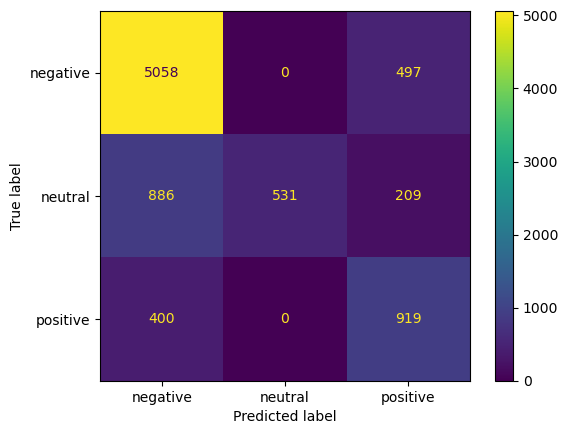

In [17]:
# make predictions for training dataset
df['predicted_sentiment'] = df['tokens'].apply(lambda x: predict_tweet_sentiment(x))

# check performance on training dataset
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
disp = ConfusionMatrixDisplay(confusion_matrix(df['sentiment'], df['predicted_sentiment']), display_labels=['negative', 'neutral', 'positive'])
disp.plot()
mod_accuracy = accuracy_score(df['sentiment'], df['predicted_sentiment'])
print(f"our ad hoc model's accuracy on training dataset: {mod_accuracy*100:.2f}%")

Let's now assess the performance of our model on the validation data (i.e. 'df_test'). 

our ad hoc model's accuracy on validation dataset: 62.33%


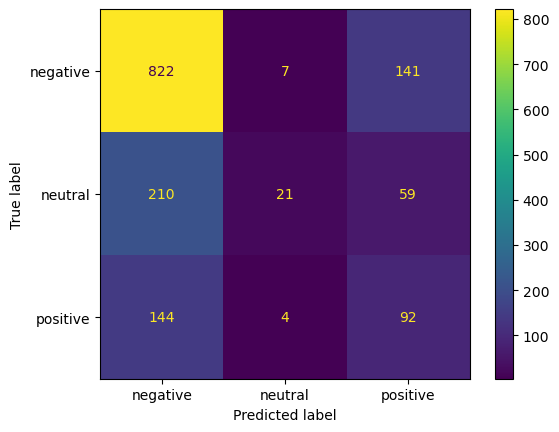

In [18]:
# make predictions for the validation/test dataset
df_test['predicted_sentiment'] = df_test['tokens'].apply(lambda x: predict_tweet_sentiment(x))

# check performance on validation/test dataset
disp = ConfusionMatrixDisplay(confusion_matrix(df_test['sentiment'], df_test['predicted_sentiment']), display_labels=['negative', 'neutral', 'positive'])
disp.plot()
mod_accuracy = accuracy_score(df_test['sentiment'], df_test['predicted_sentiment'])
print(f"our ad hoc model's accuracy on validation dataset: {mod_accuracy*100:.2f}%")

Let's stop here and think about whether we are assessing the model correctly. That is:
1. Are we using a training and validation datasets to get an idea of how our model's  __out-of-sample__ performance? 
2. Also, are we splitting the dataset at the right time to ensure there is no [__data leakage__](https://en.wikipedia.org/wiki/Leakage_(machine_learning))? 

### 2. Using a "real" ML Model

Now that we have tokenized the data, we can quickly vectorize it to get a numeric representation for each tweet. That will then give us the flexibility to select from a much broader range of commonly used machine learning models. We can still use the `df` data frame as the training dataset, and `df_test` as the validation dataset. 

Just to be sure, let's go ahead and drop the `predicted_sentiment` column from both data frames. We can also drop the `tokens_raw` column since we are no longer using it. 

In [19]:
if 'predicted_sentiment' in df.columns:
    print("removing column, predicted_sentiment, from df")
    df.drop('predicted_sentiment', axis=1, inplace=True)

if 'predicted_sentiment' in df_test.columns:
    print("removing column, predicted_sentiment, from df_test")
    df_test.drop('predicted_sentiment', axis=1, inplace=True)

print(f"df.shape: {df.shape}")
print(f"df_test.shape: {df_test.shape}")
df.head()

removing column, predicted_sentiment, from df
removing column, predicted_sentiment, from df_test
df.shape: (8500, 4)
df_test.shape: (1500, 4)


,sentiment,text,tokens_raw,tokens
3771,neutral,@JetBlue Come on and provide service from Destin- Fort Walton Beach Airport,"[@jetblue, come, provide, service, destin, -, fort, walton, beach, airport]","[@jetblue, come, provide, service, destin, -, fort, walton, beach, airport]"
6672,positive,@JetBlue u the real MVP http://t.co/jWL26G6lRw,"[@jetblue, u, real, mvp, http://t.co/jwl26g6lrw]","[@jetblue, u, real, mvp, http://t.co/jwl26g6lrw]"
7261,negative,"@SouthwestAir My brother &amp; his girlfriend’s flight Cancelled Flightled 3 times, now leaving 72 hours Late Flight and dropping letter grades at school. Help?","[@southwestair, brother, &, girlfriend, ’, flight, cancelled, flightled, 3, times, ,, leaving, 72, hours, late, flight, dropping, letter, grades, school, help]","[@southwestair, brother, &, girlfriend, ’, flight, cancel, flightled, 3, time, ,, leave, 72, hours, late, flight, drop, letter, grade, school, help]"
760,neutral,@AmericanAir More or less - after a night in a party hotel - no sleep and a 5:30 am rebook- on our way back to PHL http://t.co/4G0K0z2rei,"[@americanair, less, -, night, party, hotel, -, sleep, 5:30, rebook, -, way, back, phl, http://t.co/4g0k0z2rei]","[@americanair, less, -, night, party, hotel, -, sleep, 5:30, rebook, -, way, back, phl, http://t.co/4g0k0z2rei]"
3779,neutral,@JetBlue marks 15th birthday with 'Blumanity' paint job - @Dallas_News (blog) http://t.co/lFGR0Nifut,"[@jetblue, marks, 15th, birthday, ', blumanity, ', paint, job, -, @dallas_news, (, blog, ), http://t.co/lfgr0nifut]","[@jetblue, mark, 15th, birthday, ', blumanity, ', paint, job, -, @dallas_news, (, blog, ), http://t.co/lfgr0nifut]"


The input to the sklearn vectorizer function requires that each observation (i.e. tweet) is in the form of a string, rather than a list of tokens. So we first need to combine the individual tokens for each tweet back into a string, which we do here:

In [20]:
df['textclean'] = df['tokens'].apply(lambda x: ' '.join(x))
df.head()

,sentiment,text,tokens_raw,tokens,textclean
3771,neutral,@JetBlue Come on and provide service from Destin- Fort Walton Beach Airport,"[@jetblue, come, provide, service, destin, -, fort, walton, beach, airport]","[@jetblue, come, provide, service, destin, -, fort, walton, beach, airport]",@jetblue come provide service destin - fort walton beach airport
6672,positive,@JetBlue u the real MVP http://t.co/jWL26G6lRw,"[@jetblue, u, real, mvp, http://t.co/jwl26g6lrw]","[@jetblue, u, real, mvp, http://t.co/jwl26g6lrw]",@jetblue u real mvp http://t.co/jwl26g6lrw
7261,negative,"@SouthwestAir My brother &amp; his girlfriend’s flight Cancelled Flightled 3 times, now leaving 72 hours Late Flight and dropping letter grades at school. Help?","[@southwestair, brother, &, girlfriend, ’, flight, cancelled, flightled, 3, times, ,, leaving, 72, hours, late, flight, dropping, letter, grades, school, help]","[@southwestair, brother, &, girlfriend, ’, flight, cancel, flightled, 3, time, ,, leave, 72, hours, late, flight, drop, letter, grade, school, help]","@southwestair brother & girlfriend ’ flight cancel flightled 3 time , leave 72 hours late flight drop letter grade school help"
760,neutral,@AmericanAir More or less - after a night in a party hotel - no sleep and a 5:30 am rebook- on our way back to PHL http://t.co/4G0K0z2rei,"[@americanair, less, -, night, party, hotel, -, sleep, 5:30, rebook, -, way, back, phl, http://t.co/4g0k0z2rei]","[@americanair, less, -, night, party, hotel, -, sleep, 5:30, rebook, -, way, back, phl, http://t.co/4g0k0z2rei]",@americanair less - night party hotel - sleep 5:30 rebook - way back phl http://t.co/4g0k0z2rei
3779,neutral,@JetBlue marks 15th birthday with 'Blumanity' paint job - @Dallas_News (blog) http://t.co/lFGR0Nifut,"[@jetblue, marks, 15th, birthday, ', blumanity, ', paint, job, -, @dallas_news, (, blog, ), http://t.co/lfgr0nifut]","[@jetblue, mark, 15th, birthday, ', blumanity, ', paint, job, -, @dallas_news, (, blog, ), http://t.co/lfgr0nifut]",@jetblue mark 15th birthday ' blumanity ' paint job - @dallas_news ( blog ) http://t.co/lfgr0nifut


Now we will load the term-frequency inverse-document-frequency vectorizer from sklearn, `TfidfVectorizer`, to convert each tweet into a vector. We'll go ahead and call the resulting vectorized data, `X`, or `X_train` since it is only the training dataset. As with conventional statistical models, "_X_" represents the set of predictors, or independent variables. 

Also, note that `TfidfVectorizer` is a powerful text processing object. It has the ability to remove stop words, strip symbols, and do much of the work that our manual tokenization did. As such, we could easily use the original tweet text here, but we'll go ahead and continue with our manually tokenized data in the column, `textclean`. 

In [21]:
from sklearn.feature_extraction.text import TfidfVectorizer
#import seaborn as sns
tfidf_vectorizer = TfidfVectorizer()
X_train = tfidf_vectorizer.fit_transform(df['textclean']).toarray()
#X_train = tfidf_vectorizer.fit_transform(df['text']).toarray() # original tweet text (without our manual tokenization)

#from sklearn.feature_extraction.text import CountVectorizer
#one_hot_vectorizer = CountVectorizer(binary=True)
#tweet_matrix = one_hot_vectorizer.fit_transform(list(df['textclean']))#.toarray()

print(f"X_train.shape = {X_train.shape}")
type(X_train)

X_train.shape = (8500, 8671)


numpy.ndarray

Note that the data type for `X_train` is no longer a pandas data frame. Instead, it is a numpy ndarray. We will talk much more about the python module, numpy, and its data types in the coming week. For now, let's just think of it a more efficently implemented object than a pandas data frame (e.g. smaller memory footprint), and one that we can think of a more of a matrix than a table of data. This can be seen by how we can easily index into `X_train` without the need for methods such as `iloc` or `loc`. Here we will look at the first 5 rows and 10 columns.

In [22]:
X_train[:5, :10]

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

Looking at the output above, and back at the dimensions of `X_train` two cells back, what does this tell you about the data (aside from the size of the training data)? Specifically, what do the number of columns represent?

If you're not sure, then look at the output of the following cell. We are looking at the first row of the training dataset, `X_train` again, but looking only at the non-zero values. These are the term-frequency inverse-document-frequency values for this tweet. 

In [23]:
obs1 = list(X_train[0,:])
for i, tfidf_val in enumerate(obs1):
    if tfidf_val > 0:
        print(f"obs1 token at column i={i}, has a non-zero TF-IDF value: {tfidf_val}")

obs1 token at column i=1327, has a non-zero TF-IDF value: 0.23197575400400638
obs1 token at column i=1790, has a non-zero TF-IDF value: 0.40022186397127696
obs1 token at column i=2433, has a non-zero TF-IDF value: 0.2551460675845881
obs1 token at column i=2908, has a non-zero TF-IDF value: 0.4621055149032632
obs1 token at column i=3725, has a non-zero TF-IDF value: 0.3878075008834325
obs1 token at column i=4654, has a non-zero TF-IDF value: 0.14358409286260168
obs1 token at column i=6321, has a non-zero TF-IDF value: 0.3011629312445256
obs1 token at column i=6968, has a non-zero TF-IDF value: 0.17921221755590624
obs1 token at column i=8331, has a non-zero TF-IDF value: 0.4621055149032632


If we wanted to, we could retrieve the token associated with each column of `X_train` by using the `tfidf_vectorizer`. Let's do that now just to see if we can try to recover the tweet. You'll notice that we can't recover the ordering of the words, but rather just the set of words that were in the tweet. 

In [24]:
obs1 = list(X_train[0,:])
for i, tfidf_val in enumerate(obs1):
    if tfidf_val > 0:
        print(f"obs1 has a non-zero TF-IDF value: {tfidf_val} at col i={i} (associated with token: {tfidf_vectorizer.get_feature_names_out()[i]})")

obs1 has a non-zero TF-IDF value: 0.23197575400400638 at col i=1327 (associated with token: airport)
obs1 has a non-zero TF-IDF value: 0.40022186397127696 at col i=1790 (associated with token: beach)
obs1 has a non-zero TF-IDF value: 0.2551460675845881 at col i=2433 (associated with token: come)
obs1 has a non-zero TF-IDF value: 0.4621055149032632 at col i=2908 (associated with token: destin)
obs1 has a non-zero TF-IDF value: 0.3878075008834325 at col i=3725 (associated with token: fort)
obs1 has a non-zero TF-IDF value: 0.14358409286260168 at col i=4654 (associated with token: jetblue)
obs1 has a non-zero TF-IDF value: 0.3011629312445256 at col i=6321 (associated with token: provide)
obs1 has a non-zero TF-IDF value: 0.17921221755590624 at col i=6968 (associated with token: service)
obs1 has a non-zero TF-IDF value: 0.4621055149032632 at col i=8331 (associated with token: walton)


We can verify this by going back to our training dataset, `df`, and checking what the first observation was. Looking at the output below. As stated above, we see that the same words are present in the data but not necessarily in the same order. Disregarding word order when vectorizing text data is sometimes (informally) referred to as a "[__bag-of-words__](https://en.wikipedia.org/wiki/Bag-of-words_model)" approach. Often times, "__bag-of-words__" suggests that just the counts (i.e. __term frequency__) is used, rather than what we are using here, __term-frequency inverse-document-frequency__. Nonetheless, the underlying idea that words frequency is accounted for, but word order is neglected, is an important observation to make here.

In [25]:
df.iloc[0,:]

sentiment                                                                         neutral
text          @JetBlue Come on and provide service from Destin- Fort Walton Beach Airport
tokens_raw    [@jetblue, come, provide, service, destin, -, fort, walton, beach, airport]
tokens        [@jetblue, come, provide, service, destin, -, fort, walton, beach, airport]
textclean                @jetblue come provide service destin - fort walton beach airport
Name: 3771, dtype: object

A good default model to start with that does not require too much fine tuning, and generally performs well is a [__Random Forest__](https://en.wikipedia.org/wiki/Random_forest) model. We won't dig into the details of how an RF model works exactly, but so long as we know that it creates many decision trees on random subsets of the data, then you've got a decent idea. Before doing so, we also need to convert the labels (i.e. `df.sentiment`) to a numpy data type. We'll quickly do that now and look at the first few observations. 

In [26]:
y_train = df.sentiment.to_numpy()
y_train[:10]

array(['neutral', 'positive', 'negative', 'neutral', 'neutral',
       'negative', 'negative', 'negative', 'neutral', 'positive'],
      dtype=object)

We'll not fit the random forest model on the training data and check the performance. 

accuracy (on X_train): 0.9981


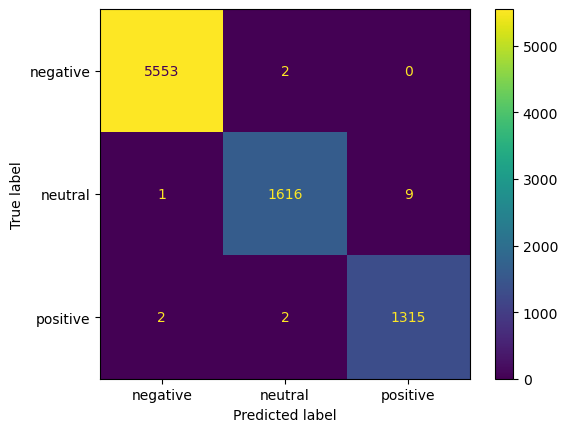

In [27]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators=200)
model = model.fit(X_train, y_train)

predictions_train = model.predict(X_train)
predictions_train

disp = ConfusionMatrixDisplay(confusion_matrix(df['sentiment'], predictions_train), display_labels=['negative', 'neutral', 'positive'])
disp.plot()
print(f"accuracy (on X_train): {accuracy_score(df['sentiment'], predictions_train):.4f}")

Wow! Accuracy of ~99% is much better than what we saw with our ad hoc model. Let's check and see how well the model does on the validation dataset now.

Notice that we are using `tfidf_vectorizer.transform()` now, and not the same method we used before on the training dataset, which was `tfidf_vectorizer.fit_transform()`. The `fit_transform` method creates the vocabulary from the training data. The `transform` method will use the vocabulary that was previously made, but if it encounters a token in the validation data that was never seen in the training data, then it will simply ignore it. This is one reason why making sure that training data for models is regularly updated.

In [28]:
df_test['textclean'] = df_test['tokens'].apply(lambda x: ' '.join(x))
X_test = tfidf_vectorizer.transform(df_test['textclean']).toarray()
X_test.shape

(1500, 8671)

accuracy (on X_test): 0.7800


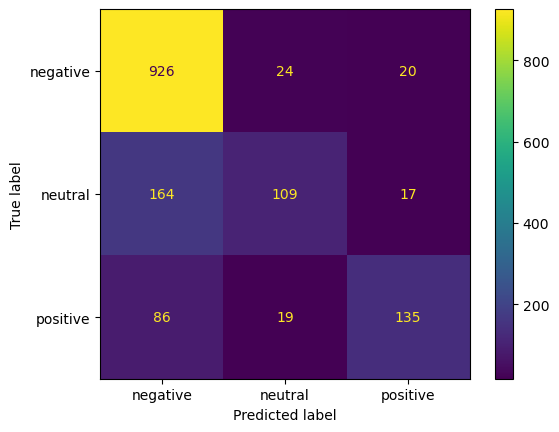

In [29]:
predictions_test = model.predict(X_test)
disp = ConfusionMatrixDisplay(confusion_matrix(df_test['sentiment'], predictions_test), display_labels=['negative', 'neutral', 'positive'])
disp.plot()
print(f"accuracy (on X_test): {accuracy_score(df_test['sentiment'], predictions_test):.4f}")

Okay, the model performance on the validation data is not nearly as good as the performance on the training dataset. That's expected to some degree. 

We may be able to improve it slightly by finding the optimal value of one of the random forest hyperparameters, e.g. `n_estimators`. However, one of the strengths of random forest is not it does a good job of overfitting. Knowing that, how do you think smaller values of `n_estimators` will affect accuracy on the validation data? How do you think larger values will affect it? Try a few different values of `n_estimators`, both larger and smaller than the default of `n_estimators=100`, to see what happens.

Below we go ahead and try many different hyperparameter values (for n_estimators) to see what the best value is. As can be seen, there is not an immediately obvious choice for the best value of the n_estimators hyperparameter, which is exactly why random forest is such a nice to model to use at the beginning. Admittedly, an RF model might not perform as well as some other machine learning models, but it is reliable and does a decent job at balancing the Bias-Variance Tradeoff right away without a lot of tuning. 

In [30]:
from sklearn.metrics import log_loss

# A function to create and fit a RF with a specific number of trees
def fitRFModel(hyperparam_value):
    rf_model = RandomForestClassifier(n_estimators=hyperparam_value, random_state=5)
    #rf_model = RandomForestClassifier(min_samples_split=hyperparam_value, random_state=1)
    rf_model.fit(X_train, y_train)
    y_train_pred_prob = rf_model.predict_proba(X_train)
    y_train_pred = rf_model.predict(X_train)
    y_val_pred_prob = rf_model.predict_proba(X_test)
    y_val_pred = rf_model.predict(X_test)
    train_loss = log_loss(df['sentiment'], y_train_pred_prob, labels=['negative', 'neutral', 'positive']) #, F.binary_cross_entropy(torch.tensor(y_train_pred), torch.tensor(y_train.to_numpy().astype(float)), reduction="mean")
    train_acc = accuracy_score(df['sentiment'], y_train_pred)
    val_loss = log_loss(df_test['sentiment'], y_val_pred_prob, labels=['negative', 'neutral', 'positive']) #F.binary_cross_entropy(torch.tensor(y_val_pred), torch.tensor(y_val.to_numpy().astype(float)), reduction="mean")
    val_acc = accuracy_score(df_test['sentiment'], y_val_pred)
    #return((train_loss.item(), val_loss.item()))
    return (train_loss, val_loss, train_acc, val_acc)

# Possible values of min_samples_split are 10 to 70 (by 5)
hyp_param_vals = list(range(5,151,10))
#hyp_param_vals = [5] + list(range(10,201,10))
metrics = []
for hp in hyp_param_vals:
    metrics.append(fitRFModel(hp))

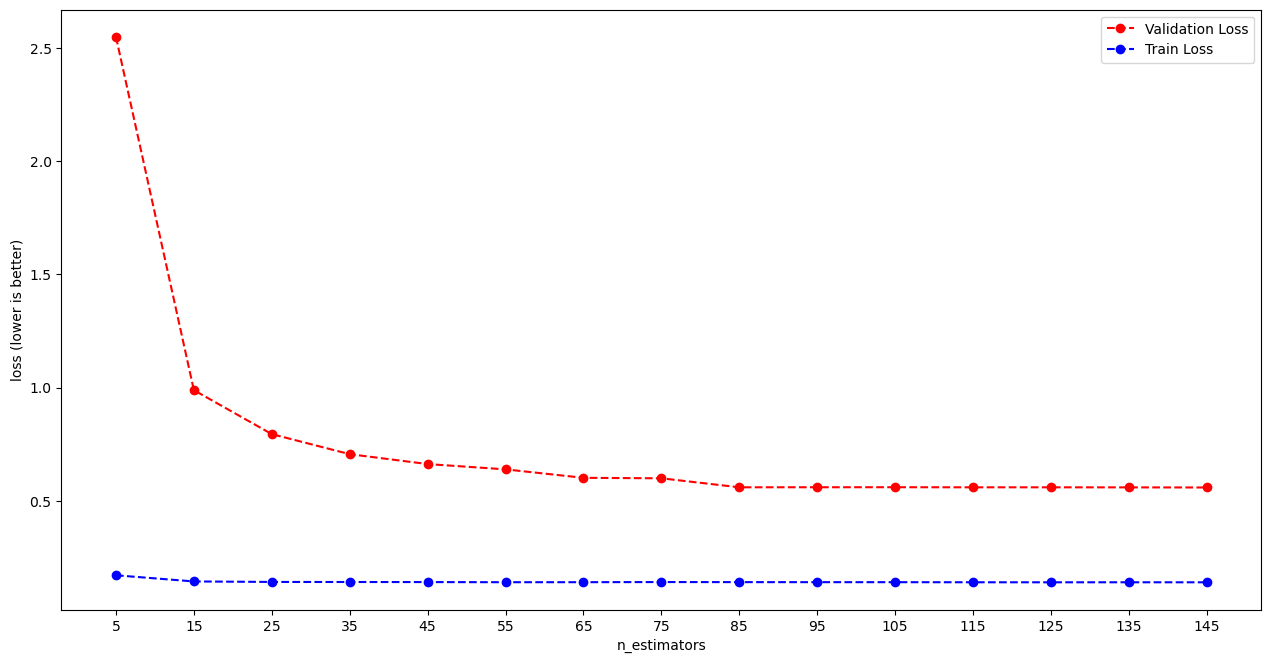

In [31]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(12, 6))
ax = fig.add_axes([0, 0, 1, 1]) #.1, 0.1, 0.8, 0.8]) # main axes
ax.plot(hyp_param_vals, [metric[1] for metric in metrics], '--ro') # validattion loss
ax.plot(hyp_param_vals, [metric[0] for metric in metrics], '--bo') # training loss
ax.legend(["Validation Loss", "Train Loss"], loc=1)
ax.set_xticks(hyp_param_vals)
ax.set(xlabel="n_estimators", ylabel="loss (lower is better)")
plt.show()

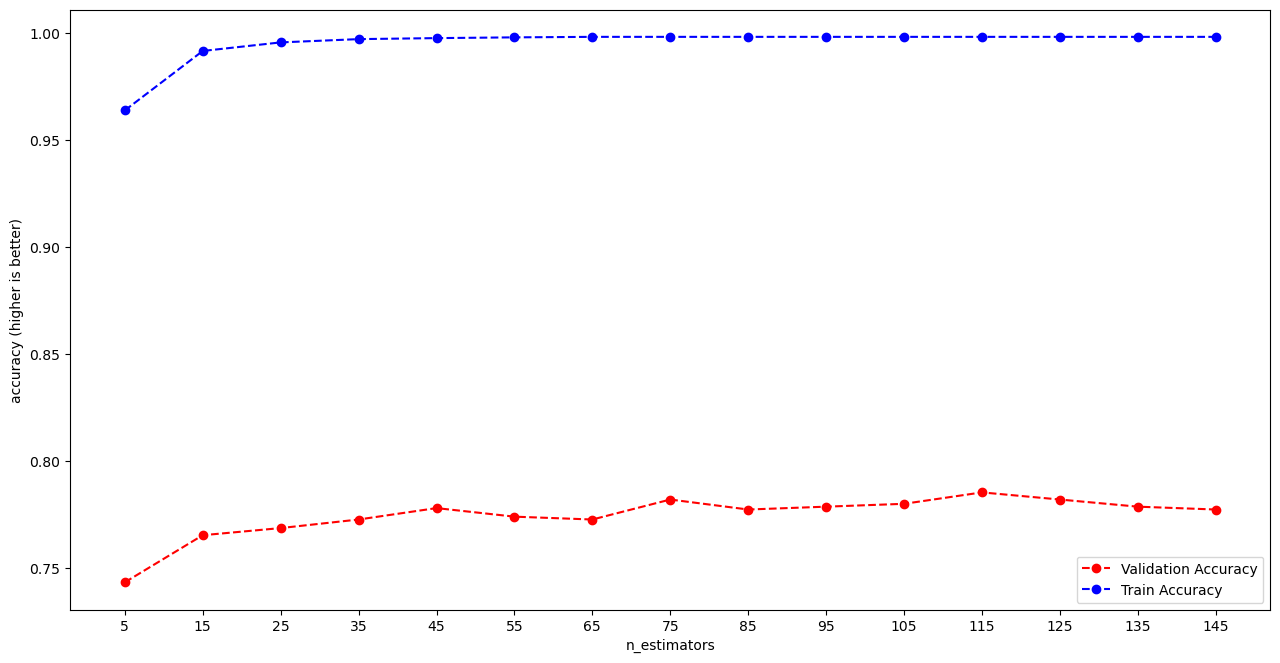

In [32]:
fig = plt.figure(figsize=(12, 6))
ax = fig.add_axes([0, 0, 1, 1]) #.1, 0.1, 0.8, 0.8]) # main axes
ax.plot(hyp_param_vals, [metric[3] for metric in metrics], '--ro') # validattion accuracy
ax.plot(hyp_param_vals, [metric[2] for metric in metrics], '--bo') # training accuracy
ax.legend(["Validation Accuracy", "Train Accuracy"], loc=4)
ax.set_xticks(hyp_param_vals)
ax.set(xlabel="n_estimators", ylabel="accuracy (higher is better)")
plt.show()